In [ ]:
conda install geopandas

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import seaborn as sns
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
df = pd.read_csv('MCI_2014_to_2019.csv',sep=',') 
df['Total'] = 1
df.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,...,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId,Total
0,-79.405228,43.656982,7801,GO-20152165447,2015-12-18T03:58:00.000Z,2015-12-18T03:59:00.000Z,Commercial,1430,100,Assault,...,Friday,3,Assault,D14,79,University (79),-79.405228,43.656982,7001,1
1,-79.307907,43.778732,7802,GO-20151417245,2015-08-15T21:45:00.000Z,2015-08-17T22:11:00.000Z,Commercial,1430,100,Assault,...,Saturday,21,Assault,D42,118,Tam O'Shanter-Sullivan (118),-79.307907,43.778732,7002,1
2,-79.225029,43.765942,7803,GO-20151421107,2015-08-16T16:00:00.000Z,2015-08-18T14:40:00.000Z,Apartment,2120,200,B&E,...,Sunday,16,Break and Enter,D43,137,Woburn (137),-79.225029,43.765942,7003,1
3,-79.140823,43.778648,7804,GO-20152167714,2015-11-26T13:00:00.000Z,2015-12-18T13:38:00.000Z,Other,2120,200,B&E,...,Thursday,13,Break and Enter,D43,133,Centennial Scarborough (133),-79.140823,43.778648,7004,1
4,-79.288361,43.691235,7805,GO-20152169954,2015-12-18T19:50:00.000Z,2015-12-18T19:55:00.000Z,Commercial,1430,100,Assault,...,Friday,19,Assault,D55,61,Taylor-Massey (61),-79.288361,43.691235,7005,1


##Data Visualisation

occurrenceyear
2014.0    31638
2015.0    32316
2016.0    32809
2017.0    34561
2018.0    36323
2019.0    37674
dtype: int64


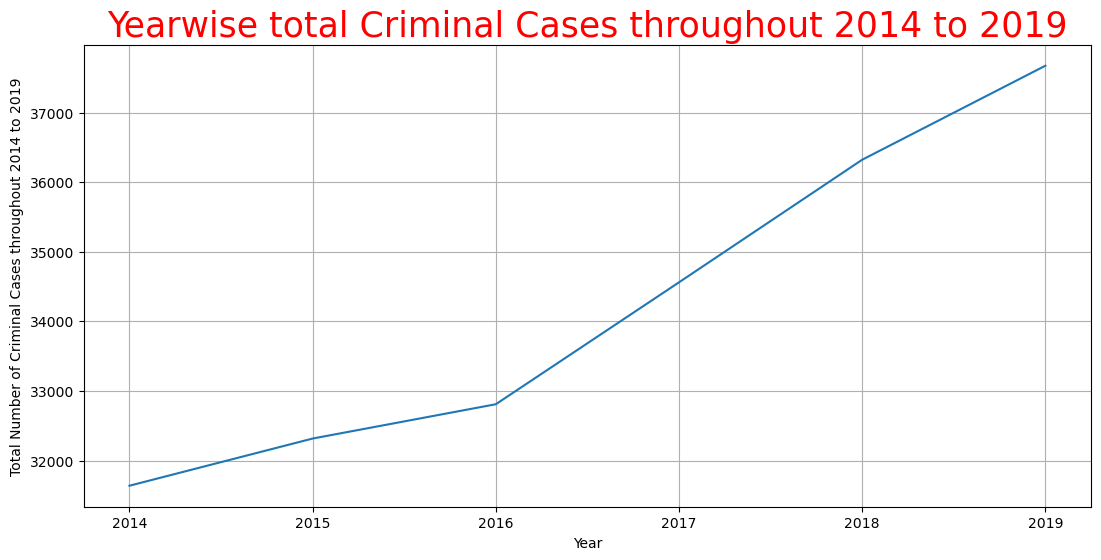

In [3]:
# Creating a Countplot
df2 = df[df['occurrenceyear'] > 2013]
yearwise_total_crime = df2.groupby('occurrenceyear').size()
print(yearwise_total_crime)

plt.figure(figsize=(13,6))
ct = yearwise_total_crime.sort_values(ascending=True)
ax = ct.plot.line()
ax.set_xlabel('Year')
ax.set_ylabel('Total Number of Criminal Cases throughout 2014 to 2019')
ax.set_title('Yearwise total Criminal Cases throughout 2014 to 2019',color = 'red',fontsize=25)
ax.grid(linestyle='-')
plt.show()


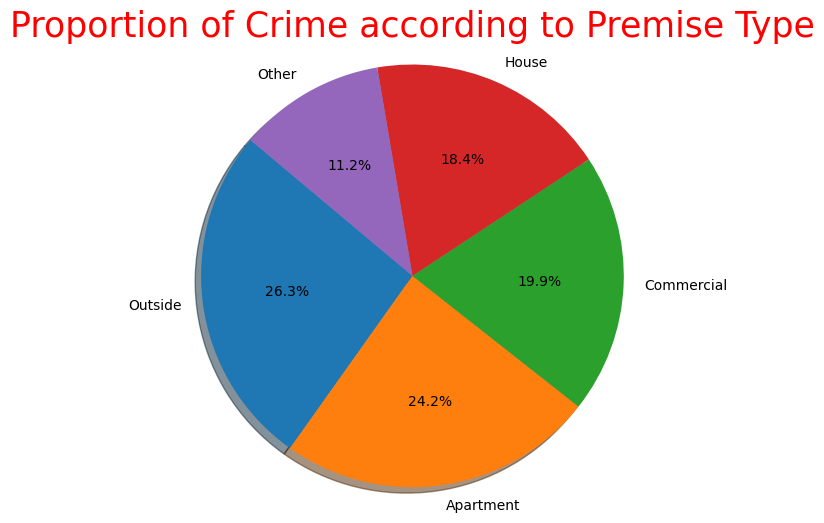

In [4]:
# Proportion of crime according to premisetype
premise_type = df.groupby('premisetype').size()
premise_type.head()
labels = ['Outside','Apartment','Commercial','House','Other']
count = [54253,49996,41081,37927,23178]
explode = (0, 0, 0, 0, 0) 

fig, ax = plt.subplots(figsize = (6,6))
ax.pie(count, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Proportion of Crime according to Premise Type", color='red', fontsize=25)
plt.show()

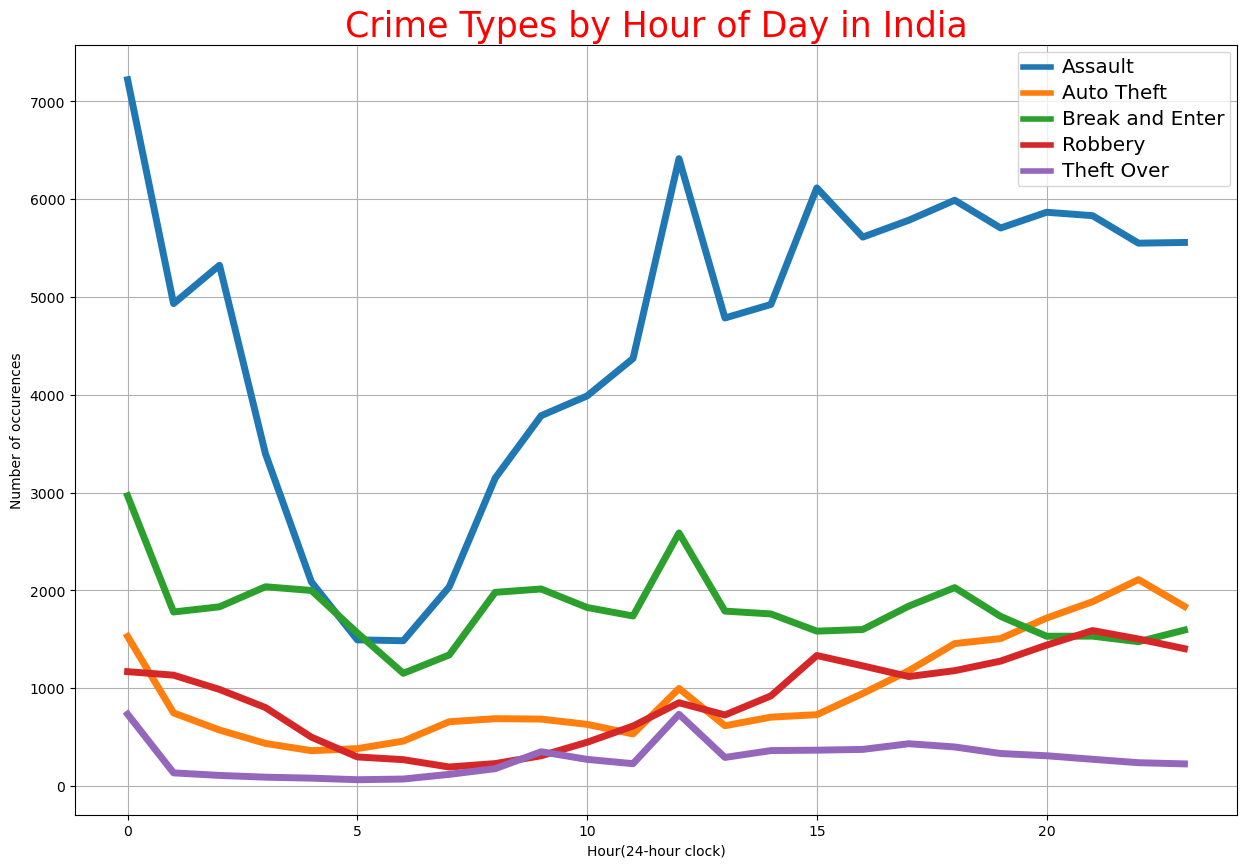

In [5]:
hour_crime_group = df.groupby(['occurrencehour','MCI'],as_index=False).agg({'Total':'sum'})
#print(hour_crime_group)

fig, ax = plt.subplots(figsize=(15,10))
hour_crime_group.groupby('MCI').plot(x="occurrencehour", y="Total", ax=ax,linewidth=5)
ax.set_xlabel('Hour(24-hour clock)')
ax.set_ylabel('Number of occurences')
ax.set_title('Crime Types by Hour of Day in India',color = 'red',fontsize=25)
ax.grid(linestyle='-')
leg = plt.legend([v[0] for v in hour_crime_group.groupby('MCI')['MCI']])
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=4)
plt.setp(leg_texts, fontsize='x-large')
plt.show()

C:\Users\begum\AppData\Local\Temp\ipykernel_3904\927577910.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  crime_count = mci_monthwise.pivot("MCI","occurrencemonth","Total" )


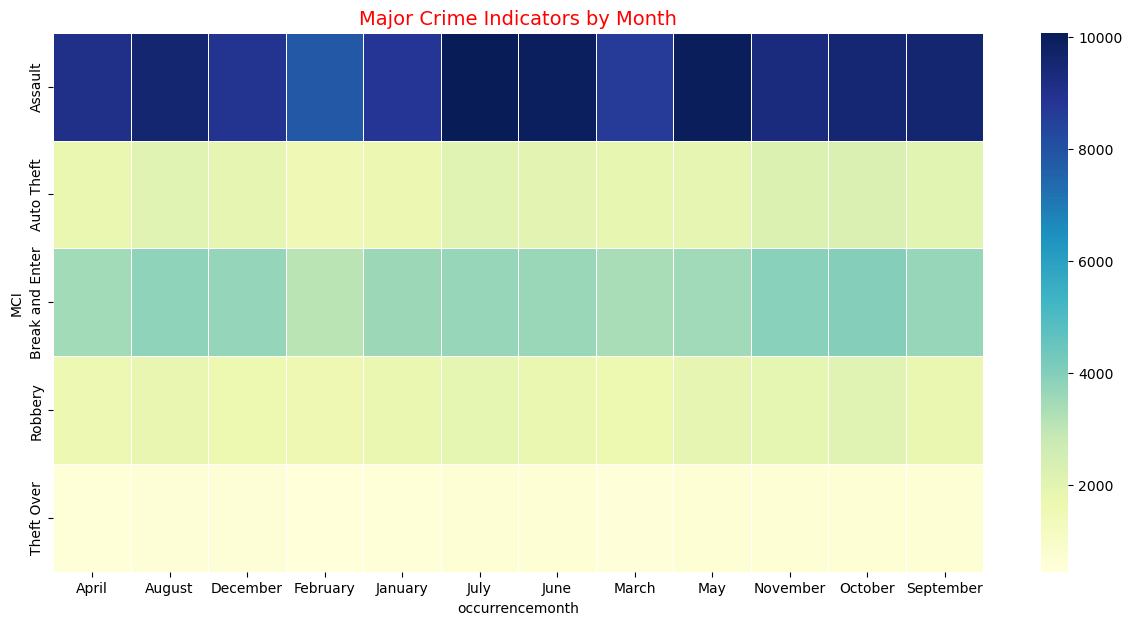

In [6]:
# Plot a heatmap
mci_monthwise = df.groupby(['occurrencemonth','MCI'],as_index=False).agg({'Total':'sum'})

plt.figure(figsize=(15, 7))
crime_count = mci_monthwise.pivot("MCI","occurrencemonth","Total" )

plt.yticks(rotation=1)
ax = sns.heatmap(crime_count,cmap="YlGnBu", linewidths=.5)
plt.title("Major Crime Indicators by Month",color = 'red',fontsize=14)
plt.show()

##Data preprocessing

In [7]:
# Columns for the models
col_list = ['occurrenceyear',	'occurrencemonth','occurrenceday','occurrencedayofyear','occurrencedayofweek','occurrencehour','MCI',	'Division',	'Hood_ID','premisetype']

# New dataframe from columns
df2 = df[col_list]
df2 = df2[df2['occurrenceyear'] > 2013]

#Factorize dependent variable column:
crime_var = pd.factorize(df2['MCI'])
df2['MCI'] = crime_var[0]
definition_list_MCI = crime_var[1]

#factorize independent variables:
premise_var = pd.factorize(df2['premisetype'])
df2['premisetype'] = premise_var[0]
definition_list_premise = premise_var[1] 

#factorize occurenceyear:
year_var = pd.factorize(df2['occurrenceyear'])
df2['occurrenceyear'] = year_var[0]
definition_list_year = year_var[1] 

#factorize occurencemonth:
month_var = pd.factorize(df2['occurrencemonth'])
df2['occurrencemonth'] = month_var[0]
definition_list_month = month_var[1] 

#factorize occurenceday:
day_var = pd.factorize(df2['occurrenceday'])
df2['occurenceday'] = day_var[0]
definition_list_day = day_var[1] 

#factorize occurencedayofweek:
dayweek_var = pd.factorize(df2['occurrencedayofweek'])
df2['occurrencedayofweek'] = dayweek_var[0]
definition_list_day = dayweek_var[1] 

#factorize division:
division_var = pd.factorize(df2['Division'])
df2['Division'] = division_var[0]
definition_list_division = division_var[1] 

#factorize HOOD_ID:
hood_var = pd.factorize(df2['Hood_ID'])
df2['Hood_ID'] = hood_var[0]
definition_list_hood = hood_var[1] 

#factorize occurencehour:
hour_var = pd.factorize(df2['occurrencehour'])
df2['occurrencehour'] = hour_var[0]
definition_list_hour = hour_var[1] 

#factorize occurencedayofyear:
dayyear_var = pd.factorize(df2['occurrencedayofyear'])
df2['occurrencedayofyear'] = dayyear_var[0]
definition_list_dayyear = dayyear_var[1] 

In [8]:
#set X and Y:
X = df2.drop(['MCI'],axis=1).values
y = df2['MCI'].values

#split the data into train and test sets for numeric encoded dataset:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

#need to OneHotEncode all the X variables for input into the classification model:
binary_encoder = OneHotEncoder(sparse=False,categories='auto')
encoded_X = binary_encoder.fit_transform(X)
X_train_OH, X_test_OH, y_train_OH, y_test_OH = train_test_split(encoded_X, y, test_size = 0.25, random_state = 21)

C:\Users\begum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# Numeric Encoded Model
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Accuracy of Random Forest : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) 
print(classification_report(y_test,y_pred, target_names=definition_list_MCI)) 

Accuracy of Random Forest :  0.6352691356100602
[[23861  2290   662    65   863]
 [ 5261  5034    67    66   272]
 [ 2991   288  1731    11   339]
 [ 1119   337    46    29   148]
 [ 2853   750   263    31  1954]]
                 precision    recall  f1-score   support

        Assault       0.66      0.86      0.75     27741
Break and Enter       0.58      0.47      0.52     10700
        Robbery       0.63      0.32      0.43      5360
     Theft Over       0.14      0.02      0.03      1679
     Auto Theft       0.55      0.33      0.41      5851

       accuracy                           0.64     51331
      macro avg       0.51      0.40      0.43     51331
   weighted avg       0.61      0.64      0.60     51331



In [10]:
#One Hot Encoded Model
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train_OH, y_train_OH)
y_pred_OH = classifier.predict(X_test_OH)

print("Accuracy of Random Forest with OneHotEncoder : ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test_OH, y_pred_OH)) 
print(classification_report(y_test_OH,y_pred_OH, target_names=definition_list_MCI))

Accuracy of Random Forest with OneHotEncoder :  0.6352691356100602
[[24536  1948   499    28   730]
 [ 5223  5157    33    54   233]
 [ 3107   253  1673     6   321]
 [ 1168   319    25    24   143]
 [ 3012   621   176    17  2025]]
                 precision    recall  f1-score   support

        Assault       0.66      0.88      0.76     27741
Break and Enter       0.62      0.48      0.54     10700
        Robbery       0.70      0.31      0.43      5360
     Theft Over       0.19      0.01      0.03      1679
     Auto Theft       0.59      0.35      0.44      5851

       accuracy                           0.65     51331
      macro avg       0.55      0.41      0.44     51331
   weighted avg       0.63      0.65      0.62     51331



In [11]:
#Balanced Class Weight doesn't make a big difference for results:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42, class_weight='balanced')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) 

print("Accuracy of Random Forest with Balanced class weight: ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) 
print(classification_report(y_test,y_pred, target_names=definition_list_MCI))

Accuracy of Random Forest with Balanced class weight:  0.6335352905651556
[[23940  2270   655    66   810]
 [ 5465  4857    56    65   257]
 [ 2966   291  1779    15   309]
 [ 1157   318    43    31   130]
 [ 2970   715   221    32  1913]]
                 precision    recall  f1-score   support

        Assault       0.66      0.86      0.75     27741
Break and Enter       0.57      0.45      0.51     10700
        Robbery       0.65      0.33      0.44      5360
     Theft Over       0.15      0.02      0.03      1679
     Auto Theft       0.56      0.33      0.41      5851

       accuracy                           0.63     51331
      macro avg       0.52      0.40      0.43     51331
   weighted avg       0.61      0.63      0.60     51331

